In [62]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import seaborn as sn
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
%matplotlib inline
print(tf.__version__)

2.4.1


In [ ]:
def load_data(data):
    images=[]
    classes=[]

    rows=pd.read_csv(data)
    rows=rows.sample(frac=1).reset_index(drop=True)
    for i,row in rows.iterrows():
        img_class=row["ClassId"]
        img_path=row["Path"]
        img_path_full=os.path.join('data', img_path)
        print(img_path_full)
        image = cv2.imread(img_path_full)
        image = cv2.resize(image,(32,32),3)
        #histogram equalization
        images.append(image)
        classes.append(img_class)

    X = np.array(images)
    y = np.array(classes)

    return X,y

XTrain,yTrain = load_data('data/Train.csv')
XTest,yTest = load_data('data/Test.csv')

In [21]:
train = np.load('train.npz')
test = np.load('test.npz')

In [22]:
XTrain = train.f.arr_0
yTrain = train.f.arr_1
XTest = test.f.arr_0
yTest = test.f.arr_1

In [23]:
#Encoding

XTrain = XTrain.astype("float32")/255.0
XTest = XTest.astype("float32")/255.0

#one-hot

yTrain = tf.keras.utils.to_categorical(yTrain)
yTest = tf.keras.utils.to_categorical(yTest)
class_totals = yTrain.sum(axis=0)
class_weight = class_totals.max() / class_totals

In [24]:
epochs = 20
learning_rate = 0.001
batch_size = 64
optimizer = Adam(lr=learning_rate, decay=learning_rate / (epochs))

In [25]:
data_aug = ImageDataGenerator(
validation_split=0.2,
rotation_range=10,
zoom_range=0.15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
vertical_flip=False)

train_data = data_aug.flow(XTrain,yTrain, batch_size=batch_size, subset='training')
val_data = data_aug.flow(XTrain,yTrain, batch_size=batch_size, subset='validation')

In [26]:
#random model to test out evaluation.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(43, activation='softmax')
])

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1843712   
_________________________________________________________________
dense_1 (Dense)              (None, 43)                22059     
Total params: 1,866,219
Trainable params: 1,866,219
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(train_data,epochs=epochs,validation_data=val_data)

Epoch 1/20
491/491 [==============================] - 30s 32ms/step - loss: 2.7933 - accuracy: 0.2544 - val_loss: 1.5047 - val_accuracy: 0.5447
Epoch 2/20
491/491 [==============================] - 14s 28ms/step - loss: 1.3591 - accuracy: 0.5860 - val_loss: 1.0819 - val_accuracy: 0.6733
Epoch 3/20
491/491 [==============================] - 14s 28ms/step - loss: 1.0231 - accuracy: 0.6869 - val_loss: 0.8987 - val_accuracy: 0.7220
Epoch 4/20
491/491 [==============================] - 14s 28ms/step - loss: 0.8291 - accuracy: 0.7451 - val_loss: 0.7741 - val_accuracy: 0.7544
Epoch 5/20
491/491 [==============================] - 14s 28ms/step - loss: 0.7053 - accuracy: 0.7857 - val_loss: 0.6687 - val_accuracy: 0.7870
Epoch 6/20
491/491 [==============================] - 14s 28ms/step - loss: 0.6145 - accuracy: 0.8136 - val_loss: 0.5628 - val_accuracy: 0.8274
Epoch 7/20
491/491 [==============================] - 14s 28ms/step - loss: 0.5421 - accuracy: 0.8337 - val_loss: 0.5176 - val_accuracy:

In [28]:
y_pred = model.predict(XTest)


In [31]:
#np.savez("predictions1",y_pred)

# Evaluation

In [54]:
yPred = np.rint(y_pred)
print(metrics.f1_score(yTest, yPred, average="macro"))
print(metrics.accuracy_score(yTest, yPred))

0.7771595508933279
0.8070467141726049


In [73]:
def plot_confusion_matrix(labels, pred_labels):
    
    cm = metrics.confusion_matrix(labels, pred_labels)
    df_cm = pd.DataFrame(cm, range(43), range(43))
    sn.heatmap(df_cm)
    plt.show


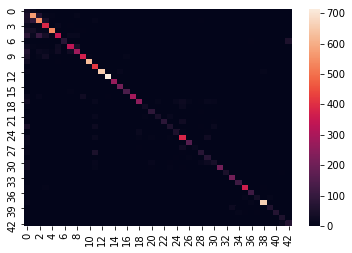

In [74]:
classes = pd.read_csv('data/signnames.csv')
classes = classes['SignName'].values.tolist()
plot_confusion_matrix(yTest.argmax(axis=1),yPred.argmax(axis=1))

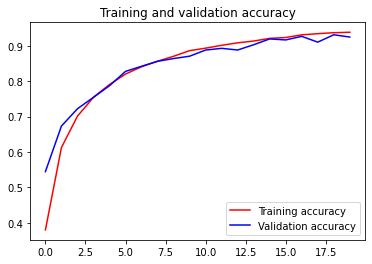

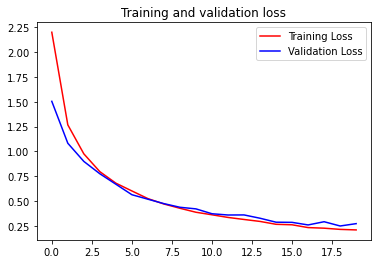

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
tf.test.gpu_device_name()